# FDT Evaluation Results Analysis

This notebook analyzes evaluation results from chat and cogex models, comparing their choices against CDT/FDT/EDT recommendations.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

## Load FDT Dataset

Load the ground truth dataset with CDT/FDT/EDT recommendations for each problem and schema.

In [ ]:
DATA_DIR = Path("../data")

# Load fdt.json
with open(DATA_DIR / "fdt.json") as f:
    fdt_data = json.load(f)

# Create lookup dict: {problem_id: {"A": {"CDT": x, "FDT": y, "EDT": z}, ...}}
ground_truth = {}
for problem in fdt_data["problems"]:
    pid = problem["id"]
    ground_truth[pid] = {}
    for schema_key in ["A", "B", "C"]:
        schema = problem["schema"][schema_key]
        ground_truth[pid][schema_key] = {
            "CDT": schema["CDT"],
            "FDT": schema["FDT"],
            "EDT": schema["EDT"]
        }

print(f"Loaded {len(ground_truth)} problems from fdt.json")
print(f"Problem IDs range: {min(ground_truth.keys())} to {max(ground_truth.keys())}")

Loaded 999 problems from fdt.json
Problem IDs range: 0 to 998


## Load Result Files

Load the qwen3-8b result files for comparison.

In [ ]:
# Load only qwen3-8b result files
chat_file = DATA_DIR / "chat-qwen3-8b.json"
cogex_file = DATA_DIR / "cogex-qwen3-8b.json"

print(f"Chat file: {chat_file.name}")
print(f"COGEX file: {cogex_file.name}")

In [ ]:
# Load result files
with open(chat_file) as f:
    chat_results = json.load(f)
with open(cogex_file) as f:
    cogex_results = json.load(f)

print(f"Chat: {len(chat_results)} problems")
print(f"COGEX: {len(cogex_results)} problems")

## Check for Missing Problems

Report which problems are missing from each result file.

In [ ]:
all_problem_ids = set(ground_truth.keys())

for name, model_results in [("Chat", chat_results), ("COGEX", cogex_results)]:
    result_ids = set(int(k) for k in model_results.keys())
    missing_ids = all_problem_ids - result_ids
    
    if missing_ids:
        print(f"{name}: MISSING {len(missing_ids)} problems")
    else:
        print(f"{name}: Complete ({len(result_ids)} problems)")

## Create Hierarchical DataFrames

For each model, create a DataFrame where:
- Index: problem_id
- Columns: MultiIndex (schema, theory) e.g., ("A", "CDT"), ("A", "FDT"), etc.
- Values: 1 if model agrees, 0 if disagrees, -1 for parse failures

In [ ]:
def create_agreement_df(model_results: dict, ground_truth: dict) -> pd.DataFrame:
    """
    Create a DataFrame comparing model choices to CDT/FDT/EDT recommendations.
    
    Args:
        model_results: Dict mapping problem_id (str) -> {"A": {"choice": int}, "B": ..., "C": ...}
        ground_truth: Dict mapping problem_id (int) -> {"A": {"CDT": int, "FDT": int, "EDT": int}, ...}
    
    Returns:
        DataFrame with MultiIndex columns (schema, theory) and values 1/0/-1
    """
    schemas = ["A", "B", "C"]
    theories = ["CDT", "FDT", "EDT"]
    
    # Create MultiIndex columns
    columns = pd.MultiIndex.from_product([schemas, theories], names=["schema", "theory"])
    
    rows = []
    row_indices = []
    
    for pid in sorted(ground_truth.keys()):
        pid_str = str(pid)
        
        # Check if this problem exists in results
        if pid_str not in model_results:
            # Problem missing from results - skip it
            continue
        
        row_data = []
        for schema in schemas:
            model_choice = model_results[pid_str][schema]["choice"]
            
            for theory in theories:
                gt_recommendation = ground_truth[pid][schema][theory]
                
                if model_choice == -1:
                    # Parse failure - set to -1
                    row_data.append(-1)
                elif model_choice == gt_recommendation:
                    # Agreement
                    row_data.append(1)
                else:
                    # Disagreement
                    row_data.append(0)
        
        rows.append(row_data)
        row_indices.append(pid)
    
    df = pd.DataFrame(rows, index=row_indices, columns=columns)
    df.index.name = "problem_id"
    return df

In [ ]:
# Create DataFrames for both models
chat_df = create_agreement_df(chat_results, ground_truth)
cogex_df = create_agreement_df(cogex_results, ground_truth)

print(f"Chat: {len(chat_df)} rows")
print(f"COGEX: {len(cogex_df)} rows")

In [ ]:
# Display sample from Chat model
print("Sample from Chat model:")
chat_df.head(10)

## Agreement Rate Analysis

Compare COGEX vs Chat model agreement with decision theory recommendations across schemas.

In [ ]:
def wilson_ci(successes: int, n: int, confidence: float = 0.95) -> tuple[float, float]:
    """
    Calculate Wilson score confidence interval for a binomial proportion.
    """
    if n == 0:
        return (0, 0)
    
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    p = successes / n
    
    denominator = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * n)) / n) / denominator
    
    return (max(0, center - margin), min(1, center + margin))


def get_agreement_stats(df: pd.DataFrame, schema: str, theory: str) -> dict:
    """Get agreement rate and confidence interval for a schema/theory."""
    col = (schema, theory)
    valid_mask = df[col] != -1
    valid_count = valid_mask.sum()
    successes = (df[col] == 1).sum()
    
    rate = successes / valid_count if valid_count > 0 else 0
    ci_low, ci_high = wilson_ci(successes, valid_count)
    
    return {
        "rate": rate,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "successes": successes,
        "n": valid_count
    }

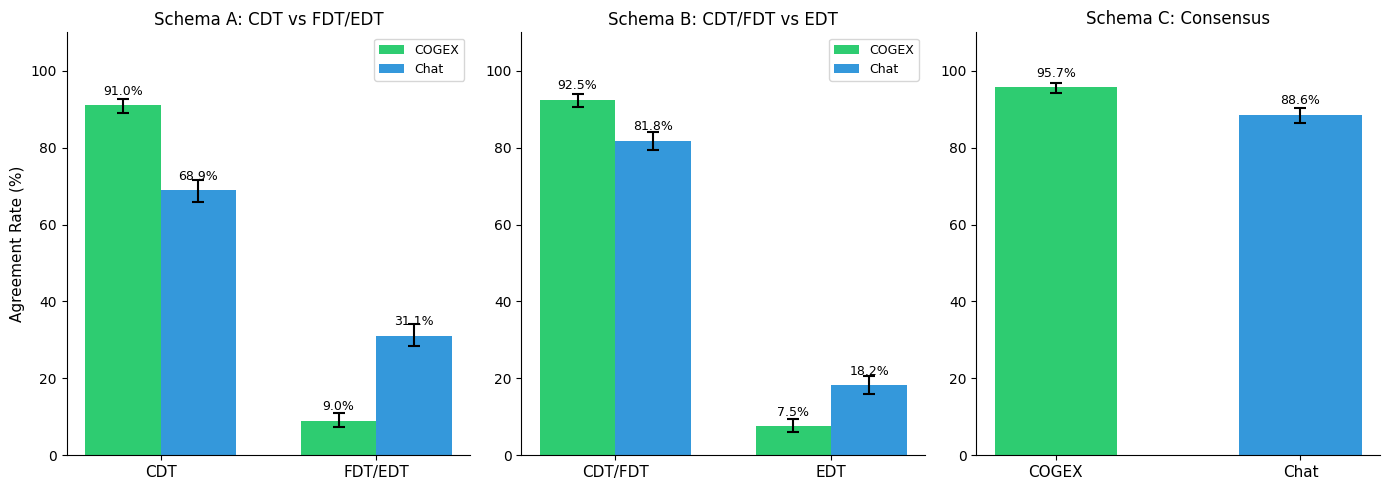

In [17]:
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Schema A: CDT vs FDT agreement rates
cogex_cdt = get_agreement_stats(cogex_df, "A", "CDT")
cogex_fdt = get_agreement_stats(cogex_df, "A", "FDT")
chat_cdt = get_agreement_stats(chat_df, "A", "CDT")
chat_fdt = get_agreement_stats(chat_df, "A", "FDT")

ax = axes[0]
x = np.array([0, 1])
width = 0.35

cogex_rates = [cogex_cdt["rate"] * 100, cogex_fdt["rate"] * 100]
cogex_errs = [
    [cogex_cdt["rate"] * 100 - cogex_cdt["ci_low"] * 100, cogex_fdt["rate"] * 100 - cogex_fdt["ci_low"] * 100],
    [cogex_cdt["ci_high"] * 100 - cogex_cdt["rate"] * 100, cogex_fdt["ci_high"] * 100 - cogex_fdt["rate"] * 100]
]
bars1 = ax.bar(x - width/2, cogex_rates, width, label="COGEX", color="#2ecc71", 
               yerr=cogex_errs, capsize=4, error_kw={"capthick": 1.5})

chat_rates = [chat_cdt["rate"] * 100, chat_fdt["rate"] * 100]
chat_errs = [
    [chat_cdt["rate"] * 100 - chat_cdt["ci_low"] * 100, chat_fdt["rate"] * 100 - chat_fdt["ci_low"] * 100],
    [chat_cdt["ci_high"] * 100 - chat_cdt["rate"] * 100, chat_fdt["ci_high"] * 100 - chat_fdt["rate"] * 100]
]
bars2 = ax.bar(x + width/2, chat_rates, width, label="Chat", color="#3498db",
               yerr=chat_errs, capsize=4, error_kw={"capthick": 1.5})

for bar, rate in zip(bars1, cogex_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{rate:.1f}%", 
            ha="center", va="bottom", fontsize=9)
for bar, rate in zip(bars2, chat_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{rate:.1f}%", 
            ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Agreement Rate (%)", fontsize=11)
ax.set_title("Schema A: CDT vs FDT/EDT", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(["CDT", "FDT/EDT"], fontsize=11)
ax.legend(fontsize=9)
ax.set_ylim(0, 110)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Schema B: CDT/FDT vs EDT agreement rates
cogex_cdt_fdt = get_agreement_stats(cogex_df, "B", "CDT")
cogex_edt = get_agreement_stats(cogex_df, "B", "EDT")
chat_cdt_fdt = get_agreement_stats(chat_df, "B", "CDT")
chat_edt = get_agreement_stats(chat_df, "B", "EDT")

ax = axes[1]
cogex_rates = [cogex_cdt_fdt["rate"] * 100, cogex_edt["rate"] * 100]
cogex_errs = [
    [cogex_cdt_fdt["rate"] * 100 - cogex_cdt_fdt["ci_low"] * 100, cogex_edt["rate"] * 100 - cogex_edt["ci_low"] * 100],
    [cogex_cdt_fdt["ci_high"] * 100 - cogex_cdt_fdt["rate"] * 100, cogex_edt["ci_high"] * 100 - cogex_edt["rate"] * 100]
]
bars1 = ax.bar(x - width/2, cogex_rates, width, label="COGEX", color="#2ecc71",
               yerr=cogex_errs, capsize=4, error_kw={"capthick": 1.5})

chat_rates = [chat_cdt_fdt["rate"] * 100, chat_edt["rate"] * 100]
chat_errs = [
    [chat_cdt_fdt["rate"] * 100 - chat_cdt_fdt["ci_low"] * 100, chat_edt["rate"] * 100 - chat_edt["ci_low"] * 100],
    [chat_cdt_fdt["ci_high"] * 100 - chat_cdt_fdt["rate"] * 100, chat_edt["ci_high"] * 100 - chat_edt["rate"] * 100]
]
bars2 = ax.bar(x + width/2, chat_rates, width, label="Chat", color="#3498db",
               yerr=chat_errs, capsize=4, error_kw={"capthick": 1.5})

for bar, rate in zip(bars1, cogex_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{rate:.1f}%", 
            ha="center", va="bottom", fontsize=9)
for bar, rate in zip(bars2, chat_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{rate:.1f}%", 
            ha="center", va="bottom", fontsize=9)

ax.set_title("Schema B: CDT/FDT vs EDT", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(["CDT/FDT", "EDT"], fontsize=11)
ax.legend(fontsize=9)
ax.set_ylim(0, 110)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Schema C: Consensus agreement rates
cogex_consensus = get_agreement_stats(cogex_df, "C", "CDT")
chat_consensus = get_agreement_stats(chat_df, "C", "CDT")

ax = axes[2]
x_c = np.array([0, 1])
width_c = 0.5

rates = [cogex_consensus["rate"] * 100, chat_consensus["rate"] * 100]
errs = [
    [cogex_consensus["rate"] * 100 - cogex_consensus["ci_low"] * 100, 
     chat_consensus["rate"] * 100 - chat_consensus["ci_low"] * 100],
    [cogex_consensus["ci_high"] * 100 - cogex_consensus["rate"] * 100, 
     chat_consensus["ci_high"] * 100 - chat_consensus["rate"] * 100]
]

bars = ax.bar(x_c, rates, width_c, color=["#2ecc71", "#3498db"],
              yerr=errs, capsize=4, error_kw={"capthick": 1.5})

for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{rate:.1f}%", 
            ha="center", va="bottom", fontsize=9)

ax.set_title("Schema C: Consensus", fontsize=12)
ax.set_xticks(x_c)
ax.set_xticklabels(["COGEX", "Chat"], fontsize=11)
ax.set_ylim(0, 110)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
## Statistical Significance Tests

def mcnemar_test(cogex_col: pd.Series, chat_col: pd.Series) -> dict:
    """
    Perform McNemar's test comparing two models on paired binary outcomes.
    
    For each problem, we have:
    - COGEX agrees (1) or not (0)
    - Chat agrees (1) or not (0)
    """
    # Filter to valid responses only (not -1)
    valid_mask = (cogex_col != -1) & (chat_col != -1)
    cogex_valid = cogex_col[valid_mask]
    chat_valid = chat_col[valid_mask]
    
    # Build contingency table
    a = ((cogex_valid == 1) & (chat_valid == 1)).sum()  # Both agree
    b = ((cogex_valid == 1) & (chat_valid == 0)).sum()  # COGEX agrees, Chat doesn't
    c = ((cogex_valid == 0) & (chat_valid == 1)).sum()  # Chat agrees, COGEX doesn't
    d = ((cogex_valid == 0) & (chat_valid == 0)).sum()  # Neither agrees
    
    # McNemar's test (with continuity correction)
    if b + c == 0:
        chi2, p_value = 0, 1.0
    else:
        chi2 = (abs(b - c) - 1)**2 / (b + c)  # With continuity correction
        p_value = 1 - stats.chi2.cdf(chi2, df=1)
    
    return {
        "contingency": [[a, b], [c, d]],
        "chi2": chi2,
        "p_value": p_value,
        "n": len(cogex_valid)
    }


def significance_stars(p: float) -> str:
    """Return significance stars based on p-value."""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    return "n.s."


print("=" * 70)
print("STATISTICAL SIGNIFICANCE TESTS (McNemar's Test)")
print("=" * 70)

# Schema A: CDT agreement
print("-" * 70)
print("SCHEMA A: CDT Agreement (COGEX vs Chat)")
print("-" * 70)
result_a_cdt = mcnemar_test(cogex_df[("A", "CDT")], chat_df[("A", "CDT")])
print(f"Contingency table:")
print(f"                 Chat=CDT   Chat≠CDT")
print(f"  COGEX=CDT        {result_a_cdt['contingency'][0][0]:4d}       {result_a_cdt['contingency'][0][1]:4d}")
print(f"  COGEX≠CDT        {result_a_cdt['contingency'][1][0]:4d}       {result_a_cdt['contingency'][1][1]:4d}")
print(f"\nMcNemar's χ² = {result_a_cdt['chi2']:.2f}, p = {result_a_cdt['p_value']:.2e} {significance_stars(result_a_cdt['p_value'])}")
print(f"n = {result_a_cdt['n']}")

# Schema A: FDT agreement (same as CDT since they're complementary in binary choice)
print("\n" + "-" * 70)
print("SCHEMA A: FDT Agreement (COGEX vs Chat)")
print("-" * 70)
result_a_fdt = mcnemar_test(cogex_df[("A", "FDT")], chat_df[("A", "FDT")])
print(f"Contingency table:")
print(f"                 Chat=FDT   Chat≠FDT")
print(f"  COGEX=FDT        {result_a_fdt['contingency'][0][0]:4d}       {result_a_fdt['contingency'][0][1]:4d}")
print(f"  COGEX≠FDT        {result_a_fdt['contingency'][1][0]:4d}       {result_a_fdt['contingency'][1][1]:4d}")
print(f"\nMcNemar's χ² = {result_a_fdt['chi2']:.2f}, p = {result_a_fdt['p_value']:.2e} {significance_stars(result_a_fdt['p_value'])}")
print(f"n = {result_a_fdt['n']}")

# Schema B: CDT/FDT agreement
print("\n" + "-" * 70)
print("SCHEMA B: CDT/FDT Agreement (COGEX vs Chat)")
print("-" * 70)
result_b_cdt = mcnemar_test(cogex_df[("B", "CDT")], chat_df[("B", "CDT")])
print(f"Contingency table:")
print(f"              Chat=CDT/FDT  Chat≠CDT/FDT")
print(f"  COGEX=CDT/FDT    {result_b_cdt['contingency'][0][0]:4d}         {result_b_cdt['contingency'][0][1]:4d}")
print(f"  COGEX≠CDT/FDT    {result_b_cdt['contingency'][1][0]:4d}         {result_b_cdt['contingency'][1][1]:4d}")
print(f"\nMcNemar's χ² = {result_b_cdt['chi2']:.2f}, p = {result_b_cdt['p_value']:.2e} {significance_stars(result_b_cdt['p_value'])}")
print(f"n = {result_b_cdt['n']}")

# Schema B: EDT agreement
print("\n" + "-" * 70)
print("SCHEMA B: EDT Agreement (COGEX vs Chat)")
print("-" * 70)
result_b_edt = mcnemar_test(cogex_df[("B", "EDT")], chat_df[("B", "EDT")])
print(f"Contingency table:")
print(f"                 Chat=EDT   Chat≠EDT")
print(f"  COGEX=EDT        {result_b_edt['contingency'][0][0]:4d}       {result_b_edt['contingency'][0][1]:4d}")
print(f"  COGEX≠EDT        {result_b_edt['contingency'][1][0]:4d}       {result_b_edt['contingency'][1][1]:4d}")
print(f"\nMcNemar's χ² = {result_b_edt['chi2']:.2f}, p = {result_b_edt['p_value']:.2e} {significance_stars(result_b_edt['p_value'])}")
print(f"n = {result_b_edt['n']}")

# Schema C: Consensus agreement
print("\n" + "-" * 70)
print("SCHEMA C: Consensus Agreement (COGEX vs Chat)")
print("-" * 70)
result_c = mcnemar_test(cogex_df[("C", "CDT")], chat_df[("C", "CDT")])
print(f"Contingency table:")
print(f"                 Chat=Cons  Chat≠Cons")
print(f"  COGEX=Cons       {result_c['contingency'][0][0]:4d}       {result_c['contingency'][0][1]:4d}")
print(f"  COGEX≠Cons       {result_c['contingency'][1][0]:4d}       {result_c['contingency'][1][1]:4d}")
print(f"\nMcNemar's χ² = {result_c['chi2']:.2f}, p = {result_c['p_value']:.2e} {significance_stars(result_c['p_value'])}")
print(f"n = {result_c['n']}")

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001, n.s. not significant\n")
print(f"{'Comparison':<35} {'χ²':>10} {'p-value':>15} {'Sig':>8}")
print("-" * 70)
print(f"{'Schema A: CDT':<35} {result_a_cdt['chi2']:>10.2f} {result_a_cdt['p_value']:>15.2e} {significance_stars(result_a_cdt['p_value']):>8}")
print(f"{'Schema A: FDT':<35} {result_a_fdt['chi2']:>10.2f} {result_a_fdt['p_value']:>15.2e} {significance_stars(result_a_fdt['p_value']):>8}")
print(f"{'Schema B: CDT/FDT':<35} {result_b_cdt['chi2']:>10.2f} {result_b_cdt['p_value']:>15.2e} {significance_stars(result_b_cdt['p_value']):>8}")
print(f"{'Schema B: EDT':<35} {result_b_edt['chi2']:>10.2f} {result_b_edt['p_value']:>15.2e} {significance_stars(result_b_edt['p_value']):>8}")
print(f"{'Schema C: Consensus':<35} {result_c['chi2']:>10.2f} {result_c['p_value']:>15.2e} {significance_stars(result_c['p_value']):>8}")

STATISTICAL SIGNIFICANCE TESTS (McNemar's Test)

Comparing COGEX vs Chat agreement with decision theory recommendations.
McNemar's test is appropriate for paired binary data (same problems, different models).

----------------------------------------------------------------------
SCHEMA A: CDT Agreement (COGEX vs Chat)
----------------------------------------------------------------------
Contingency table:
                 Chat=CDT   Chat≠CDT
  COGEX=CDT         633        276
  COGEX≠CDT          55         35

McNemar's χ² = 146.22, p = 0.00e+00 ***
n = 999

----------------------------------------------------------------------
SCHEMA A: FDT Agreement (COGEX vs Chat)
----------------------------------------------------------------------
Contingency table:
                 Chat=FDT   Chat≠FDT
  COGEX=FDT          35         55
  COGEX≠FDT         276        633

McNemar's χ² = 146.22, p = 0.00e+00 ***
n = 999

----------------------------------------------------------------------
SCH